# Text Classification using Support Vector Machines (SVM)

## Problem Statement

Text classification tasks, such as categorizing news articles or customer feedback, often involve high-dimensional data and require effective machine learning models for accurate classification. Support Vector Machines (SVM), with their ability to separate data using hyperplanes, can be very effective in such cases, especially for tasks like document classification. This project aims to use SVM to classify text data based on pre-defined categories.

## Objectives

1. **Implement SVM for text classification**: Focus on linear and non-linear classification.
2. **Data Pre-processing**: Use TF-IDF and Bag of Words for feature extraction.
3. **Hyperparameter Tuning**: Optimize SVM performance using Grid Search.
4. **Evaluation**: Assess model performance using accuracy, precision, recall, and F1-score.
5. **Comparison**: Compare SVM performance with Random Forest.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet as wn
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import model_selection, naive_bayes, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Ensure NLTK data is downloaded
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Ensure plots are displayed inline
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jaiha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jaiha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jaiha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jaiha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Data Loading and Preprocessing

In [2]:
# Set seed for reproducibility
np.random.seed(500)

# Load the dataset
# Using relative path to work in the user's directory
try:
    Corpus = pd.read_csv("corpus.csv", encoding='latin-1')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'corpus.csv' not found. Please ensure the file is in the same directory.")
    # Fallback to dummy data if needed (optional)
    # raise

# Display first few rows
print(f"\nDataset Shape: {Corpus.shape}")
Corpus.head()

Dataset loaded successfully.

Dataset Shape: (10000, 2)


,text,label
0,Stuning even for the non-gamer: This sound tr...,__label__2
1,The best soundtrack ever to anything.: I'm re...,__label__2
2,Amazing!: This soundtrack is my favorite musi...,__label__2
3,Excellent Soundtrack: I truly like this sound...,__label__2
4,"Remember, Pull Your Jaw Off The Floor After H...",__label__2


### Data Cleaning and Text Preprocessing

1.  **Remove blank rows**
2.  **Lower casing**
3.  **Tokenization**
4.  **Remove Stop words & Lemmatization**

In [6]:
# 1. Remove blank rows
Corpus['text'].dropna(inplace=True)

# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda: wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

def text_preprocessing(text):
    # 2. Change all the text to lower case
    text = str(text).lower()

    # 3. Tokenization
    text_words_list = word_tokenize(text)

    # 4. Remove Stop words, Non-Numeric and perform Word Stemming/Lemmatization
    Final_words = []
    word_Lemmatized = WordNetLemmatizer()
    
    for word, tag in pos_tag(text_words_list):
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word, tag_map[tag[0]])
            Final_words.append(word_Final)
            
    return str(Final_words)

print("Processing text... This might take a moment.")
Corpus['text_final'] = Corpus['text'].apply(text_preprocessing)
print("Text preprocessing complete.")
Corpus[['text', 'text_final']].head()

Processing text... This might take a moment.
Text preprocessing complete.


,text,text_final
0,Stuning even for the non-gamer: This sound tr...,"['stun', 'even', 'sound', 'track', 'beautiful'..."
1,The best soundtrack ever to anything.: I'm re...,"['best', 'soundtrack', 'ever', 'anything', 're..."
2,Amazing!: This soundtrack is my favorite musi...,"['amaze', 'soundtrack', 'favorite', 'music', '..."
3,Excellent Soundtrack: I truly like this sound...,"['excellent', 'soundtrack', 'truly', 'like', '..."
4,"Remember, Pull Your Jaw Off The Floor After H...","['remember', 'pull', 'jaw', 'floor', 'hear', '..."


## 2. Train-Test Split and Encoding

In [7]:
# Split the data
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['text_final'], Corpus['label'], test_size=0.3)

# Label Encode the target variable
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.transform(Test_Y)

print("Classes:", Encoder.classes_)

Classes: ['__label__1 ' '__label__2 ']


## 3. Feature Extraction (TF-IDF)

In [8]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(Corpus['text_final'])

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

print("TF-IDF Shape:", Train_X_Tfidf.shape)

TF-IDF Shape: (7000, 5000)


## 4. Model Training and Evaluation

In [9]:
# 1. Naive Bayes (Baseline)
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf, Train_Y)
predictions_NB = Naive.predict(Test_X_Tfidf)

print("Naive Bayes Accuracy -> ", accuracy_score(predictions_NB, Test_Y) * 100)

# 2. SVM (Linear Kernel)
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf, Train_Y)
predictions_SVM = SVM.predict(Test_X_Tfidf)

print("SVM Accuracy Score -> ", accuracy_score(predictions_SVM, Test_Y) * 100)

Naive Bayes Accuracy ->  83.06666666666666
SVM Accuracy Score ->  84.63333333333334


## 5. Hyperparameter Tuning using Grid Search

In [10]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

print("Starting Grid Search...")
grid = GridSearchCV(svm.SVC(), param_grid, refit=True, verbose=2, cv=3)
grid.fit(Train_X_Tfidf, Train_Y)

print("\nBest Parameters found:", grid.best_params_)

# Evaluate best model
best_svm = grid.best_estimator_
pred_best_svm = best_svm.predict(Test_X_Tfidf)
print("Optimized SVM Accuracy -> ", accuracy_score(pred_best_svm, Test_Y) * 100)

Starting Grid Search...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  12.8s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  12.9s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=  13.7s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  14.6s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  16.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=  16.4s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=  14.5s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=  13.4s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=  13.3s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=  15.1s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=  14.5s
[CV] END ...............

## 6. Detailed Evaluation Report

Classification Report (Optimized SVM):
              precision    recall  f1-score   support

 __label__1        0.86      0.85      0.86      1538
 __label__2        0.85      0.85      0.85      1462

    accuracy                           0.85      3000
   macro avg       0.85      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



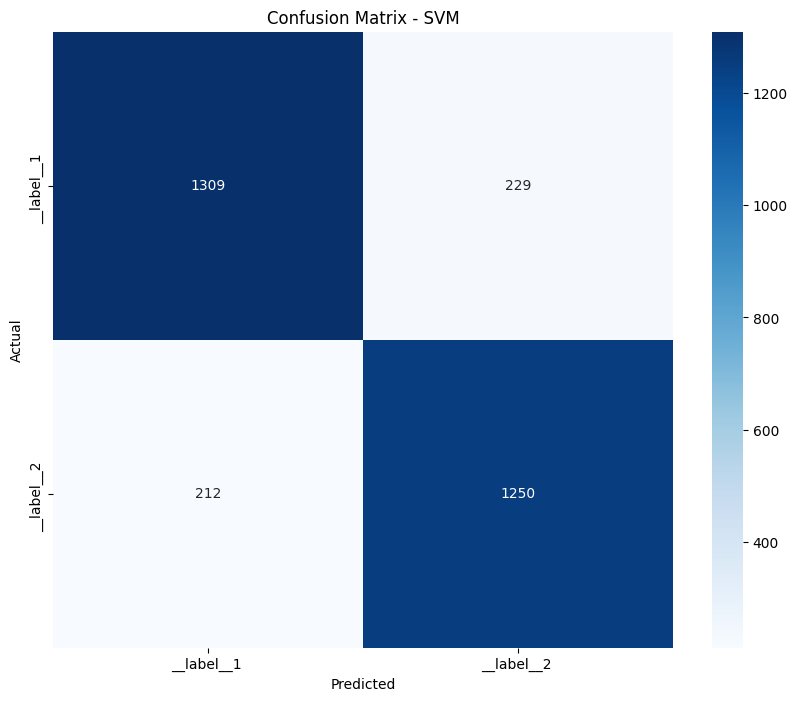

In [11]:
print("Classification Report (Optimized SVM):")
print(classification_report(Test_Y, pred_best_svm, target_names=Encoder.classes_))

# Confusion Matrix
conf_mat = confusion_matrix(Test_Y, pred_best_svm)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=Encoder.classes_, yticklabels=Encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - SVM')
plt.show()

## 7. Comparison with Random Forest

In [12]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(Train_X_Tfidf, Train_Y)
predictions_RF = rf_clf.predict(Test_X_Tfidf)

print("Random Forest Accuracy -> ", accuracy_score(predictions_RF, Test_Y) * 100)
print("\nClassification Report (Random Forest):")
print(classification_report(Test_Y, predictions_RF, target_names=Encoder.classes_))

Random Forest Accuracy ->  81.83333333333334

Classification Report (Random Forest):
              precision    recall  f1-score   support

 __label__1        0.82      0.82      0.82      1538
 __label__2        0.81      0.81      0.81      1462

    accuracy                           0.82      3000
   macro avg       0.82      0.82      0.82      3000
weighted avg       0.82      0.82      0.82      3000

